# Getting started with CUDA

## Setup

In [1]:
import torch, os, math
import torchvision as tv
import torchvision.transforms.functional as tvf
from torchvision import io
import matplotlib.pyplot as plt
from torch.utils.cpp_extension import load_inline
import cv2 as cv

/home/gaozhe/anaconda3/envs/triton/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/gaozhe/anaconda3/envs/triton/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# img = io.read_image('puppy.jpg')
img = cv.imread('puppy.jpg')    # [Height, Width, Channel]
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)    # 转RGB

img = torch.tensor(img)
img = img.permute(2, 0, 1)        # HWC->CHW
print(img.shape)
img[:2,:3,:4]

torch.Size([3, 1066, 1600])


tensor([[[117, 119, 117, 113],
         [119, 129, 129, 113],
         [130, 126, 122, 115]],

        [[ 83,  85,  85,  80],
         [ 85,  97,  97,  82],
         [ 98,  93,  89,  83]]], dtype=torch.uint8)

In [3]:
def show_img(x, figsize=(4,3), **kwargs):
    plt.figure(figsize=figsize)
    plt.axis('off')
    if len(x.shape)==3: x = x.permute(1,2,0)  # CHW -> HWC
    plt.imshow(x.cpu(), **kwargs)

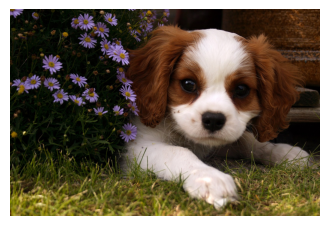

In [4]:
show_img(img)

In [5]:
img2 = tvf.resize(img, 150, antialias=True)     # 短边调整至150像素，长边按原宽高比缩放；并采用抗锯齿
ch,h,w = img2.shape
ch,h,w,h*w

(3, 150, 225, 33750)

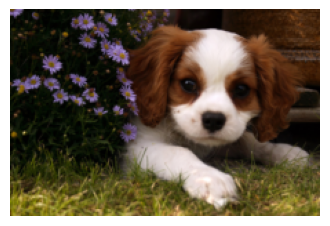

In [6]:
show_img(img2)      # 图像不会被截断，而是被缩放，不会丢失图像信息（会用插值法重新计算像素值）

## RGB -> Grey

### 灰度图公式
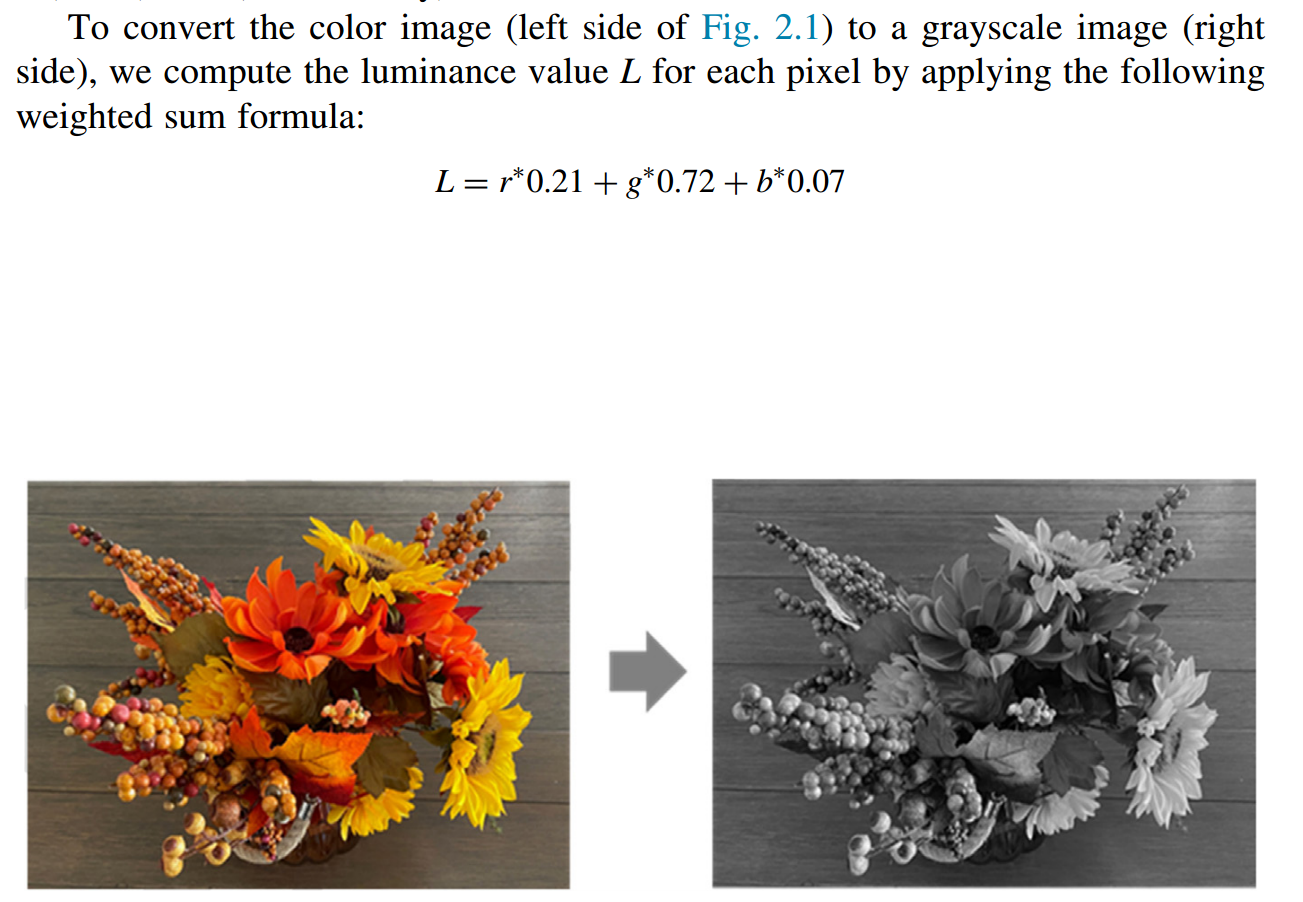

### Basic Python

In [7]:
def rgb2grey_py(x):
    c,h,w = x.shape
    n = h*w             # 每个通道像素数量
    x = x.flatten()     # 一维展开
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    for i in range(n): res[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]   # 三个通道对应位置按公式求和
    return res.view(h,w)    # 单通道

In [8]:
%%time
img_g = rgb2grey_py(img2)

CPU times: user 1.25 s, sys: 4.81 ms, total: 1.26 s
Wall time: 1.26 s


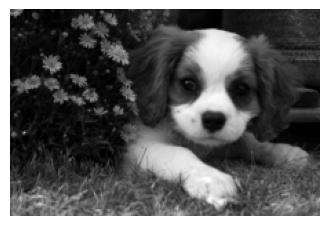

In [9]:
show_img(img_g, cmap='gray')

### Python Kernel

In [10]:
def run_kernel(f, times, *args):            # python函数模拟调用内核（不是并行）
    for i in range(times): f(i, *args)

NB: A kernel can not return anything. It can only change contents of things passed to it.

In [11]:
def rgb2grey_k(i, x, out, n):
    out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]

In [12]:
def rgb2grey_pyk(x):
    c,h,w = x.shape
    n = h*w
    x = x.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    run_kernel(rgb2grey_k, h*w, x, res, n)      # 运行h*w次内核
    return res.view(h,w)

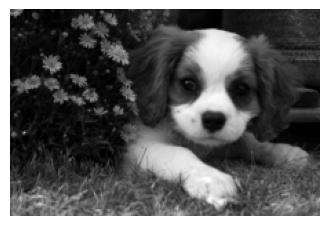

In [13]:
img_g = rgb2grey_pyk(img2)
show_img(img_g, cmap='gray')

### Python Block Kernel

1. **Streaming Multiprocessors (SMs):** In NVIDIA GPUs, SMs are the fundamental units of execution. Each SM can execute multiple threads concurrently.
2. **Thread Blocks:** A thread block is a group of threads that can cooperate among themselves through shared memory and synchronization. All threads in a block are executed on the same SM. This means they can share resources such as shared memory and can synchronize their execution with each other.
3. **Shared Memory:** Shared memory is a small memory space on the GPU that is shared among the threads in a block. It is much faster than global memory (the main GPU memory), but it is also limited in size. Threads in the same block can use shared memory to share data with each other efficiently.

- The RTX 3090, based on the Ampere architecture, has 82 SMs.
- Each SM in GA10x GPUs contain 128 CUDA Cores, four third-generation Tensor Cores, a 256 KB Register File, and 128 KB of L1/Shared Memory
- In CUDA, all threads in a block have the potential to run concurrently. However, the actual concurrency depends on the number of CUDA cores per SM and the resources required by the threads.

In [14]:
128*82

10496

In [15]:
def blk_kernel(f, blocks, threads, *args):
    for i in range(blocks):
        for j in range(threads): f(i, j, threads, *args)

In [16]:
def rgb2grey_bk(blockidx, threadidx, blockdim, x, out, n):
    i = blockidx*blockdim + threadidx       # blockdim表示一个block有多少threads
    if i<n: out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]

In [17]:
def rgb2grey_pybk(x):
    c,h,w = x.shape
    n = h*w
    x = x.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)    # 1D tensor , length = h*w
    threads = 256                           # 每块256线程
    blocks = int(math.ceil(h*w/threads))
    blk_kernel(rgb2grey_bk, blocks, threads, x, res, n)
    return res.view(h,w)    # view成h*w 2D tensor

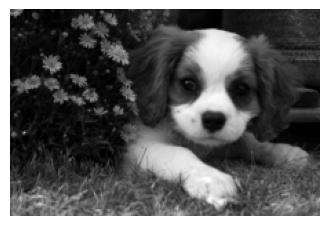

In [18]:
img_g = rgb2grey_pybk(img2)
show_img(img_g, cmap='gray')

### CUDA Setup

In [19]:
os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [20]:
%load_ext wurlitzer

In [21]:
def load_cuda(cuda_src, cpp_src, funcs, opt=False, verbose=False):
    return load_inline(cuda_sources=[cuda_src], cpp_sources=[cpp_src], functions=funcs,
                       extra_cuda_cflags=["-O2"] if opt else [], verbose=verbose, name="inline_ext")

In [22]:
cuda_begin = r'''
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a + b - 1) / b;}     # ceiling division
'''

### CUDA kernel

- 2^31 max blocks for dim 0, 2^16 max for dims 1 & 2
- 1024 max threads per block (use a multiple of 32)

In [23]:
cuda_src = cuda_begin + r'''
__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int n) {  // x是char型数组
    int i = blockIdx.x*blockDim.x + threadIdx.x;        // 计算当前线程位置
    if (i<n) out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n];
}

torch::Tensor rgb_to_grayscale(torch::Tensor input) {
    CHECK_INPUT(input);
    int h = input.size(1);
    int w = input.size(2);
    printf("h*w: %d*%d\n", h, w);
    auto output = torch::empty({h,w}, input.options());
    int threads = 256;
    rgb_to_grayscale_kernel<<<cdiv(w*h,threads), threads>>>(       // 用"<<<"指定block和thread个数
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w*h);    // tensor强制转换为char型数组
    C10_CUDA_KERNEL_LAUNCH_CHECK();     // just do it
    return output;
}'''

In [24]:
cpp_src = "torch::Tensor rgb_to_grayscale(torch::Tensor input);"

In [28]:
module = load_cuda(cuda_src, cpp_src, ['rgb_to_grayscale'], verbose=True)

Using /home/gaozhe/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
No modifications detected for re-loaded extension module inline_ext, skipping build step...
Loading extension module inline_ext...


In [30]:
!ls /home/gaozhe/.cache/torch_extensions/py310_cu121/inline_ext

build.ninja  cuda.cu  cuda.cuda.o  inline_ext.so  main.cpp  main.o


In [31]:
dir(module)

['__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'rgb_to_grayscale']

In [32]:
[o for o in dir(module) if o[0]!='_']

['rgb_to_grayscale']

In [33]:
!cat /home/gaozhe/.cache/torch_extensions/py310_cu121/inline_ext/build.ninja

ninja_required_version = 1.3
cxx = c++
nvcc = /usr/local/cuda/bin/nvcc

cflags = -DTORCH_EXTENSION_NAME=inline_ext -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/gaozhe/anaconda3/envs/triton/lib/python3.10/site-packages/torch/include -isystem /home/gaozhe/anaconda3/envs/triton/lib/python3.10/site-packages/torch/include/torch/csrc/api/include -isystem /home/gaozhe/anaconda3/envs/triton/lib/python3.10/site-packages/torch/include/TH -isystem /home/gaozhe/anaconda3/envs/triton/lib/python3.10/site-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /home/gaozhe/anaconda3/envs/triton/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17
post_cflags = 
cuda_cflags = -DTORCH_EXTENSION_NAME=inline_ext -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/gaozhe/anaconda3/

In [34]:
imgc = img.contiguous().cuda()      # put the data onto GPU

In [35]:
%%time
res = module.rgb_to_grayscale(imgc).cpu()   # 在GPU上计算完再送回cpu, 相当于手动同步，避免GPU与CPU并行导致的时间计算错误
h,w = res.shape
h,w,h*w

CPU times: user 1.3 ms, sys: 100 µs, total: 1.4 ms
Wall time: 1.1 ms


(1066, 1600, 1705600)

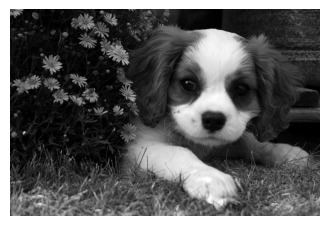

In [36]:
show_img(res, cmap='gray')

## Matmul

### Get data

In [37]:
import gzip,pickle
from urllib.request import urlretrieve
from pathlib import Path
from torch import tensor

In [38]:
import requests
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'
if not path_gz.exists(): 
    urlretrieve(MNIST_URL, path_gz)

In [39]:
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))
x_train.shape,x_train.type()

(torch.Size([50000, 784]), 'torch.FloatTensor')

In [40]:
imgs = x_train.reshape((-1,28,28))
imgs.shape

torch.Size([50000, 28, 28])

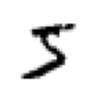

In [41]:
show_img(imgs[0], cmap='gray_r', figsize=(1,1))

In [42]:
torch.manual_seed(1)
weights = torch.randn(784,10)
weights

tensor([[-1.5256, -0.7502, -0.6540,  ..., -1.6091, -0.7121,  0.3037],
        [-0.7773, -0.2515, -0.2223,  ..., -1.1608,  0.6995,  0.1991],
        [ 0.8657,  0.2444, -0.6629,  ..., -1.4465,  0.0612, -0.6177],
        ...,
        [ 0.5063,  0.4656, -0.2634,  ...,  0.6452,  0.4298, -1.2936],
        [ 0.5171,  1.0315,  0.8120,  ..., -0.1046,  2.2588, -0.2793],
        [-1.4899,  0.3898, -0.5454,  ..., -0.1923, -0.5076,  0.5439]])

### Python matmul

In [43]:
m1 = x_valid[:5]
m2 = weights
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [44]:
ar,ac = m1.shape # n_rows * n_cols
br,bc = m2.shape
(ar,ac),(br,bc)

((5, 784), (784, 10))

In [45]:
t1 = torch.zeros(ar, bc)
t1.shape

torch.Size([5, 10])

In [46]:
for i in range(ar):         # 5
    for j in range(bc):     # 10
        for k in range(ac): # 784
            t1[i,j] += m1[i,k] * m2[k,j]

In [47]:
t1.shape

torch.Size([5, 10])

In [48]:
import numpy as np
np.set_printoptions(precision=2, linewidth=140)
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)

In [49]:
t1

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [50]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac): c[i,j] += a[i,k] * b[k,j]       
    return c

In [51]:
%time _=matmul(m1, m2)

CPU times: user 744 ms, sys: 4.26 ms, total: 748 ms
Wall time: 747 ms


In [52]:
ar*bc*ac        # O(mnk)

39200

### 2d Python kernel

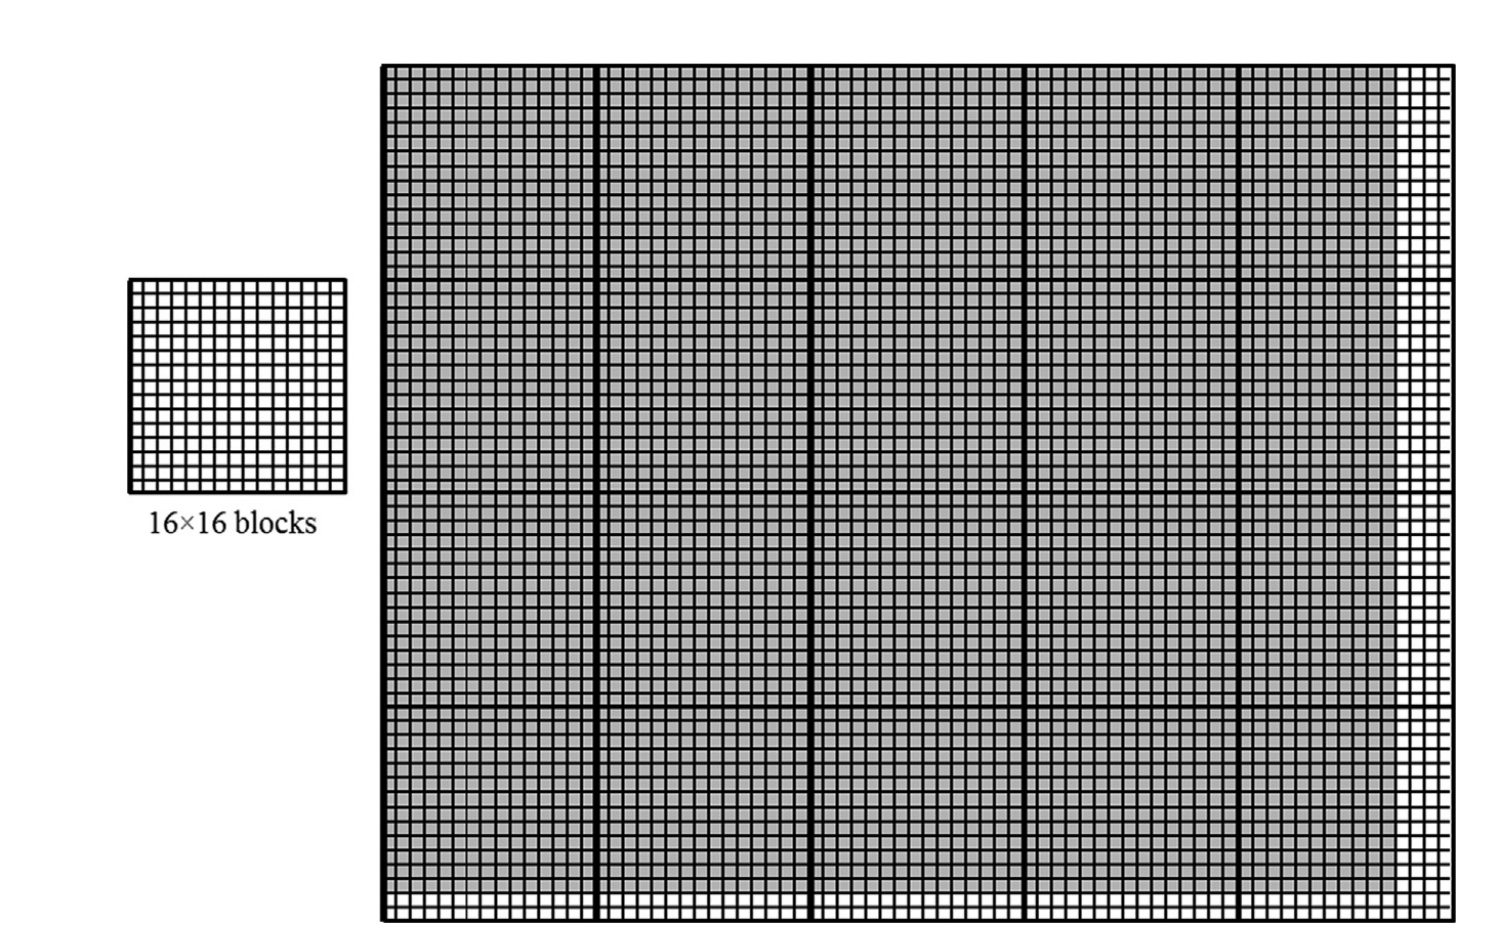

In [53]:
from types import SimpleNamespace as ns

In [54]:
def blk_kernel2d(f, blocks, threads, *args):
    for i0 in range(blocks.y):          # 有几行block
        for i1 in range(blocks.x):      # 有几列block
            for j0 in range(threads.y):
                for j1 in range(threads.x):     # for each thread
                    f(ns(x=i1,y=i0), ns(x=j1,y=j0), threads, *args)     # ns用于创建变量的属性

In [55]:
def matmul_bk(blockidx, threadidx, blockdim, m, n, out, h, w, k):
    r = blockidx.y*blockdim.y + threadidx.y     # r是在输出矩阵中的行号 = 第几行的块 * 一块有多少行 + 当前块的第几行（一行是一个线程）
    c = blockidx.x*blockdim.x + threadidx.x     # c是在输出矩阵中的列号
    
    if (r>=h or c>=w): return
    o = 0.
    for i in range(k): o += m[r*k+i] * n[i*w+c]     # m[r, i] * n[i, c]
    out[r*w+c] = o          # out[r, c]

In [56]:
def matmul_2d(m, n):
    h,k  = m.shape
    k2,w = n.shape
    assert k==k2, "Size mismatch!"
    output = torch.zeros(h, w, dtype=m.dtype)
    tpb = ns(x=16,y=16)         # threads per block 一个block为16*16
    blocks = ns(x=math.ceil(w/tpb.x), y=math.ceil(h/tpb.y))
    blk_kernel2d(matmul_bk, blocks, tpb,
                 m.flatten(), n.flatten(), output.flatten(), h, w, k)
    return output

In [57]:
res = matmul_2d(m1, m2)
torch.isclose(t1, res).all()

tensor(True)

### Broadcasting

In [58]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar): c[i] = (a[i,:,None] * b).sum(dim=0)
    return c

In [59]:
torch.isclose(t1,matmul(m1, m2)).all()

tensor(True)

In [60]:
%time _=matmul(m1, m2)

CPU times: user 0 ns, sys: 770 µs, total: 770 µs
Wall time: 534 µs


In [61]:
m1 = x_train
tr = matmul(m1, m2)
tr.shape

torch.Size([50000, 10])

In [62]:
%time _=matmul(m1, m2)

CPU times: user 1.87 s, sys: 9.27 ms, total: 1.88 s
Wall time: 1.03 s


In [63]:
ar,ac = m1.shape
br,bc = m2.shape
ar*bc*ac

392000000

### CUDA matmul

+ output矩阵的每个元素都是一个cuda thread

In [64]:
cuda_src = cuda_begin + r'''
__global__ void matmul_k(float* m, float* n, float* out, int h, int w, int k) {
    int r = blockIdx.y*blockDim.y + threadIdx.y;
    int c = blockIdx.x*blockDim.x + threadIdx.x;

    if (r>=h || c>=w) return;
    float o = 0;
    for (int i = 0; i<k; ++i) o += m[r*k+i] * n[i*w+c];
    out[r*w+c] = o;
}

torch::Tensor matmul(torch::Tensor m, torch::Tensor n) {
    CHECK_INPUT(m); CHECK_INPUT(n);
    int h = m.size(0);
    int w = n.size(1);
    int k = m.size(1);
    TORCH_CHECK(k==n.size(0), "Size mismatch!");
    auto output = torch::zeros({h, w}, m.options());

    dim3 tpb(16,16);
    dim3 blocks(cdiv(w, tpb.x), cdiv(h, tpb.y));
    matmul_k<<<blocks, tpb>>>(
        m.data_ptr<float>(), n.data_ptr<float>(), output.data_ptr<float>(), h, w, k);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}
'''

In [65]:
cpp_src = "torch::Tensor matmul(torch::Tensor m, torch::Tensor n);"

In [75]:
module = load_cuda(cuda_src, cpp_src, ['matmul'])

ImportError: /home/gaozhe/.cache/torch_extensions/py310_cu121/inline_ext/inline_ext_v1.so: cannot open shared object file: No such file or directory

In [72]:
m1c,m2c = m1.contiguous().cuda(), m2.contiguous().cuda()

In [73]:
torch.isclose(tr,module.matmul(m1c, m2c).cpu(), atol=1e-5).all()

AttributeError: module 'inline_ext' has no attribute 'matmul'

In [74]:
%%time
res=module.matmul(m1c, m2c).cpu()
res.shape

AttributeError: module 'inline_ext' has no attribute 'matmul'

### Pytorch

In [76]:
torch.isclose(tr,(m1c@m2c).cpu(), atol=1e-5).all()

tensor(True)

In [77]:
%timeit -n 10 _=(m1c@m2c).cpu()

568 µs ± 86.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### RGB->Grey CUDA 3d

In [78]:
cuda_src = cuda_begin + r'''
__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int w, int h) {
    int c = blockIdx.x*blockDim.x + threadIdx.x;
    int r = blockIdx.y*blockDim.y + threadIdx.y;

    if (c<w && r<h) {
        int i = r*w + c;
        int n = h*w;
        out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n];
    }
}

torch::Tensor rgb_to_grayscale(torch::Tensor input) {
    CHECK_INPUT(input);
    int h = input.size(1);
    int w = input.size(2);
    torch::Tensor output = torch::empty({h,w}, input.options());
    dim3 tpb(16,16);
    dim3 blocks(cdiv(w, tpb.x), cdiv(h, tpb.y));
    rgb_to_grayscale_kernel<<<blocks, tpb>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w, h);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}'''

In [ ]:
module = load_cuda(cuda_src, cpp_src, ['rgb_to_grayscale'])

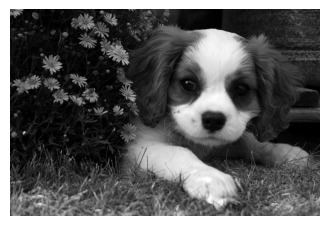

In [80]:
res = module.rgb_to_grayscale(imgc).cpu()
show_img(res, cmap='gray')